# Recomendação via Fatorização de matrizes (Matrix factorization)

Num projeto anterior, fizemos o completamento de matrizes (por exemplo para sistemas de recomendação como o Netflix) usando uma abordagem *convexa*: algoritmos de otimização de um problema com regularização convexa (norma nuclear). 

Uma segunda abordagem bem sucedida é estimar a matriz não observada $X^*$ resolvendo o problema:

$$\min_X f(X)=f(U,V):=\frac 1 2 \|U V^\top - Y\|^2_F,$$

onde $Y\in {\mathbb R}^{m\times n}$ é a matriz observada, $U\in {\mathbb R}^{m\times r}$, $V\in {\mathbb R}^{n\times r}$ and $r<\min\{m,n\}$. O gradiente é dado por 

$$
\nabla f(X) = [(UV^\top -Y) V, (UV^\top-Y)^\top U].
$$

Note que diferentemente do caso convexo (onde tínhamos a penalização $\lambda>0$ da norma nuclear como hyper-parâmetro), nesta abordagem temos uma estimativa do posto $r$ como hyper-parâmetro. A idéia aqui é "regularizar" a solução com posto $r$ impondo a fatorização $U V^\top$. Do ponto de vista computacional, a diferença é que o problema é não convexo. Entretanto, algoritmos de otimização iterativos funcionam bem na prática. 

Iremos utilizar os dados [Movielens 100K dataset](https://grouplens.org/datasets/movielens/100k/). Em particular usamos o arquivo `u.data` desta pasta, gravado em `~/datasets`. Este arquivo tem avaliações de filmes de 943 usuários e 1682 filmes. Começamos carregando alguns módulos necessários:

In [18]:
#Chamando módulos necessários:
import numpy as np
import scipy.linalg as LA
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import scipy.sparse as spr
import scipy.sparse.linalg as spr_LA

À seguir iremos carregar os dados e escrevê-los numa matriz esparsa $Y$.

In [19]:
#Carregando dados:
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('C:\\Users\\dudda\\Downloads\\u.data', sep='\t', names=names)
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]

#Criando a matriz Y de avaliações:
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]

Y = ratings
m, n = Y.shape
print("As dimensões de Y são:", m, n)

As dimensões de Y são: 943 1682


# Exercício 1: Funções auxiliares

1. Construa uma função `f()` que toma $X=(U,V)$ e retorna o valor funcional $f(X)=\frac 1 2 \|U V^\top - Y\|^2_F$.
2. Construa uma função `df()` que toma $X=(U,V)$ e retorna o gradiente $\nabla f(X) = [(UV^\top -Y) V, (UV^\top-Y)^\top U]$.
3. Construa uma função `J()` que dada matriz $D$ retorna a norma de Frobenius $\Vert D\Vert_F$.

In [20]:
# 1. Função f(U, V): calcula o valor funcional f(X)
def f(U, V):
    """
    Calcula o valor funcional f(X) = (1/2) ||UV^T - Y||_F^2.
    
    Parâmetros:
    - U: matriz de fatores de tamanho (m, r)
    - V: matriz de fatores de tamanho (n, r)
    
    Retorna:
    - Valor funcional (1/2) ||UV^T - Y||_F^2
    """
    UV = U @ V.T  # Produto das matrizes U e V transposta
    residual = UV - Y  # Erro entre UV^T e Y
    frobenius_norm_squared = np.sum(residual**2)  # ||UV^T - Y||_F^2
    return 0.5 * frobenius_norm_squared

# 2. Função df(U, V): calcula o gradiente da função de custo
def df(U, V):
    """
    Calcula o gradiente da função f(X).
    
    Parâmetros:
    - U: matriz de fatores de tamanho (m, r)
    - V: matriz de fatores de tamanho (n, r)
    
    Retorna:
    - grad_U: gradiente em relação a U
    - grad_V: gradiente em relação a V
    """
    UV = U @ V.T  # Produto das matrizes U e V transposta
    residual = UV - Y  # Erro entre UV^T e Y
    
    # Gradientes em relação a U e V
    grad_U = residual @ V  # (m, n) @ (n, r) -> (m, r)
    grad_V = residual.T @ U  # (n, m) @ (m, r) -> (n, r)
    
    return grad_U, grad_V

# 3. Função J(D): calcula a norma de Frobenius ||D||_F
def J(D):
    """
    Calcula a norma de Frobenius de uma matriz D.
    
    Parâmetros:
    - D: matriz cujos elementos devem ser usados para calcular a norma de Frobenius
    
    Retorna:
    - Norma de Frobenius ||D||_F
    """
    frobenius_norm = np.sqrt(np.sum(D**2))  # Raiz da soma dos quadrados dos elementos de D
    return frobenius_norm

# Inicialização

À seguir ponha `r=20` e inicialize $X_0=(U_0,V_0)$ aleatoriamente de uma normal multivariada. Para tanto use
`np.random.randn()`. Ponha `N=30000` para o número de iterações. 

In [21]:
r = 20

# the starting point 
np.random.seed(0)
X0 = np.random.randn(m + n, r)

# number of iterations
N = 30000

In [22]:
# Dimensões da matriz observada Y
m, n = Y.shape

# Separando X0 em U0 e V0
U0 = X0[:m, :]  # U0 é a parte superior com m linhas
V0 = X0[m:, :]  # V0 é a parte inferior com n linhas

# Conferindo as formas de U0 e V0
print("Forma de U0:", U0.shape)
print("Forma de V0:", V0.shape)

Forma de U0: (943, 20)
Forma de V0: (1682, 20)


# Exercício 2: Método do gradiente

Construa uma função `gd(J, df, x0, la=1, numb_iter=100)` que toma como entrada as funções `J()`, `df`, o ponto inicial `x0`, o passo `la` e o número de iterações `numb_iter` e implementa o método gradiente iniciando de `x0`. Esta função deve retornar a sequência de valores da função `J(df(x))` em cada um dos iterados `x`, isto é, a sequência das normas dos gradientes ao longo da trajetória do método. A função também deve retornar o último iterado. 

Implemente a função com passo `la=1./L` com `L=1000`.

In [23]:
# Função de gradiente descendente
def gd(J, df, x0, la=1, numb_iter=100):
    """
    Implementa o método de gradiente descendente.
    
    Parâmetros:
    - J: função de custo que retorna a norma de Frobenius
    - df: função que retorna os gradientes em relação a U e V
    - x0: ponto inicial (U0, V0) concatenado
    - la: tamanho do passo (lambda)
    - numb_iter: número de iterações
    
    Retorna:
    - grad_seq: sequência das normas dos gradientes ao longo das iterações
    - x: último iterado (U, V)
    """
    # Separar x0 em U e V
    m = Y.shape[0]
    U, V = x0[:m, :], x0[m:, :]
    
    grad_seq = []  # Para armazenar as normas dos gradientes

    for i in range(numb_iter):
        # Calcula o gradiente no ponto atual
        grad_U, grad_V = df(U, V)
        
        # Calcula a norma do gradiente atual (Frobenius)
        grad_norm = np.sqrt(np.sum(grad_U**2) + np.sum(grad_V**2))
        grad_seq.append(grad_norm)
        
        # Atualiza U e V usando o passo la
        U = U - la * grad_U
        V = V - la * grad_V
        
    # Retorna a sequência de normas dos gradientes e o último ponto iterado (U, V)
    return grad_seq, (U, V)

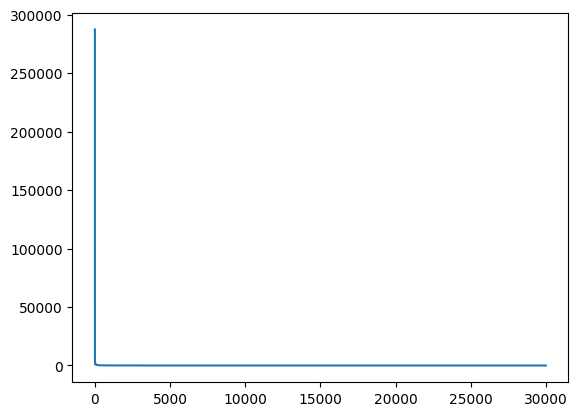

In [24]:
# gradient descent
L = 1000
f1 = gd(J, df, X0, 1./L, numb_iter=N)
plt.plot(f1[0])

# Exercício 3: Método do gradiente acelerado

Construa uma função `accel_gd(J, df, x0, la=1, numb_iter=100)` que toma como entrada as funções `J()`, `df`, o ponto inicial `x0`, o passo `la` e o número de iterações `numb_iter` e implementa o método gradiente com aceleração de Nesterov iniciando de `y_0=x0` e $t_0=1$:
\begin{align*}
X_{k+1}&:= Y_k - la\nabla f(Y_k),\\
t_{k+1} &:= \frac{1+\sqrt{1+4t_k^2}}{2},\\
Y_{k+1} &:= X_{k+1} + \frac{t_{k}-1}{t_{k+1}}(X_{k+1}-X_{k}).
\end{align*}
Esta função deve retornar a sequência de valores da função `J(df(y))` em cada um dos iterados `y`, isto é, a sequência das normas dos gradientes de $Y_k$ ao longo da trajetória do método. A função também deve retornar o último iterado. 

Implemente a função com passo `la=1./L` com `L=30000`.

In [25]:
# Função do gradiente acelerado (Nesterov)
def accel_gd(J, df, x0, la=1, numb_iter=100):
    """
    Implementa o método de gradiente acelerado de Nesterov.
    
    Parâmetros:
    - J: função de custo que retorna a norma de Frobenius
    - df: função que retorna os gradientes em relação a U e V
    - x0: ponto inicial (U0, V0) concatenado
    - la: tamanho do passo (lambda)
    - numb_iter: número de iterações
    
    Retorna:
    - grad_seq: sequência das normas dos gradientes ao longo das iterações
    - x: último iterado (U, V)
    """
    # Separar x0 em U e V
    m = Y.shape[0]
    U, V = x0[:m, :], x0[m:, :]

    # Inicializando Y0 = X0 e t0 = 1
    Y_U, Y_V = U.copy(), V.copy()
    t_k = 1
    
    grad_seq = []  # Para armazenar as normas dos gradientes
    X_U, X_V = U.copy(), V.copy()  # Para armazenar Xk+1 e Xk

    for k in range(numb_iter):
        # Calcula o gradiente no ponto atual Y_k
        grad_U, grad_V = df(Y_U, Y_V)
        
        # Atualiza X_k+1
        X_U_new = Y_U - la * grad_U
        X_V_new = Y_V - la * grad_V

        # Calcula t_k+1
        t_k_new = (1 + np.sqrt(1 + 4 * t_k**2)) / 2
        
        # Atualiza Y_k+1
        Y_U_new = X_U_new + ((t_k - 1) / t_k_new) * (X_U_new - X_U)
        Y_V_new = X_V_new + ((t_k - 1) / t_k_new) * (X_V_new - X_V)
        
        # Calcula a norma do gradiente no ponto atual e armazena
        grad_norm = np.sqrt(np.sum(grad_U**2) + np.sum(grad_V**2))
        grad_seq.append(grad_norm)
        
        # Atualiza as variáveis para a próxima iteração
        X_U, X_V = X_U_new, X_V_new
        Y_U, Y_V = Y_U_new, Y_V_new
        t_k = t_k_new

    # Retorna a sequência de normas dos gradientes e o último ponto iterado (U, V)
    return grad_seq, (X_U, X_V)

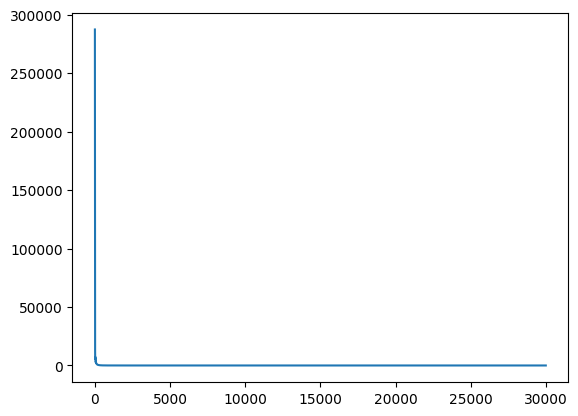

In [26]:
# Nesterov accelerated gradient descent
L = 30000
f2 = accel_gd(J, df, X0, 1./L, numb_iter=N)
plt.plot(f2[0])

# Exercício 4: Adagrad-Norm

Construa uma função `ad_grad_norm(J, df, x0, b0=0.5, eta=1, numb_iter=100)` que toma como entrada as funções `J()`, `df`, o ponto inicial `x0`, parametros positivos `b0` e `eta` e o número de iterações `numb_iter` e implementa o método Adagrad-Norm iniciando de `x0`:
\begin{align*}
X_{k+1}&:= X_k - \frac{\eta}{\sqrt{b_0^2 + \sum_{j=1}^k\Vert\nabla f(X_j)\Vert_2^2}} \nabla f(X_k).
\end{align*}
Esta função deve retornar a sequência de valores da função `J(df(x))` em cada um dos iterados `x`, isto é, a sequência das normas dos gradientes de $X_k$ ao longo da trajetória do método. A função também deve retornar o último iterado. 

Implemente a função com `b0=0.5` e `eta=1`.

In [27]:
# Função Adagrad-Norm
def ad_grad_norm(J, df, x0, b0=0.5, eta=1, numb_iter=100):
    """
    Implementa o método Adagrad-Norm.
    
    Parâmetros:
    - J: função de custo que retorna a norma de Frobenius
    - df: função que retorna os gradientes em relação a U e V
    - x0: ponto inicial (U0, V0) concatenado
    - b0: parâmetro positivo inicial
    - eta: taxa de aprendizado
    - numb_iter: número de iterações
    
    Retorna:
    - grad_seq: sequência das normas dos gradientes ao longo das iterações
    - x: último iterado (U, V)
    """
    # Separar x0 em U e V
    m = Y.shape[0]
    U, V = x0[:m, :], x0[m:, :]

    # Inicializar a soma acumulada das normas dos gradientes
    accum_grad_norm_sq = 0

    grad_seq = []  # Para armazenar as normas dos gradientes

    for k in range(numb_iter):
        # Calcula o gradiente no ponto atual X_k
        grad_U, grad_V = df(U, V)

        # Calcula a norma 2 do gradiente atual
        grad_norm_sq = np.sum(grad_U**2) + np.sum(grad_V**2)

        # Atualiza a soma acumulada das normas dos gradientes
        accum_grad_norm_sq += grad_norm_sq

        # Calcula o passo adaptativo
        adaptive_step = eta / np.sqrt(b0**2 + accum_grad_norm_sq)

        # Atualiza X_k+1
        U -= adaptive_step * grad_U
        V -= adaptive_step * grad_V

        # Calcula e armazena a norma do gradiente no ponto atual
        grad_norm = np.sqrt(grad_norm_sq)
        grad_seq.append(grad_norm)

    # Retorna a sequência de normas dos gradientes e o último ponto iterado (U, V)
    return grad_seq, (U, V)

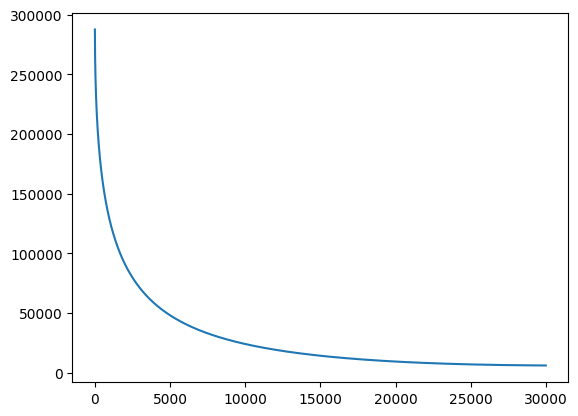

In [28]:
# Adagrad-Norm
f3 = ad_grad_norm(J, df, X0, b0=0.5, eta=1, numb_iter=N)
plt.plot(f3[0])

# Exercício 5: Adam

Construa uma função `adam(J, df, x0, alpha, beta1, beta2, epsilon, numb_iter)` que toma como entrada as funções `J()`, `df`, o ponto inicial `x0`, parametros positivos `alpha`, `beta1`, `beta2`, `epsilon` e o número de iterações `numb_iter` e implementa o método Adam iniciando de `x0`, $m_0=0$, $v_0=0$ e $k=0$: para cada $j$ézima coordenada:
\begin{align*}
m_{k+1}[j] &:= \beta_1\cdot m_{k}[j] + (1-\beta_1)\cdot\nabla f(X_k)[j],\\
v_{k+1}[j] &:= \beta_2\cdot v_{k}[j] + (1-\beta_2)\cdot(\nabla f(X_k)[j])^2,\\
\hat m_{k+1}[j] &:= \frac{1}{1-\beta_1^{k+1}}m_{k+1}[j],\\
\hat v_{k+1}[j] &:= \frac{1}{1-\beta_2^{k+1}}v_{k+1}[j],\\
X_{k+1}[j] &:= X_{k}[j] - \frac{\alpha}{\sqrt{\hat v_{k+1}[j]} + \epsilon}\hat m_{k+1}[j].
\end{align*}
Esta função deve retornar a sequência de valores da função `J(df(x))` em cada um dos iterados `x`, isto é, a sequência das normas dos gradientes de $X_k$ ao longo da trajetória do método. A função também deve retornar o último iterado. 

Implemente a função com `alpha=0.001`, `beta1=0.9`, `beta2=0.999`, `epsilon=10**(-8)`. 

In [29]:

# Função Adam
def adam(J, df, x0, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, numb_iter=100):
    """
    Implementa o método Adam.
    
    Parâmetros:
    - J: função de custo que retorna a norma de Frobenius
    - df: função que retorna os gradientes em relação a U e V
    - x0: ponto inicial (U0, V0) concatenado
    - alpha: taxa de aprendizado
    - beta1: parâmetro de decaimento para o primeiro momento (m)
    - beta2: parâmetro de decaimento para o segundo momento (v)
    - epsilon: termo de regularização para evitar divisões por zero
    - numb_iter: número de iterações
    
    Retorna:
    - grad_seq: sequência das normas dos gradientes ao longo das iterações
    - x: último iterado (U, V)
    """
    # Separar x0 em U e V
    m = Y.shape[0]
    U, V = x0[:m, :], x0[m:, :]

    # Inicializar os momentos de primeira ordem (m) e segunda ordem (v)
    m_U, m_V = np.zeros_like(U), np.zeros_like(V)
    v_U, v_V = np.zeros_like(U), np.zeros_like(V)

    grad_seq = []  # Para armazenar as normas dos gradientes

    for k in range(1, numb_iter + 1):
        # Calcula o gradiente no ponto atual X_k
        grad_U, grad_V = df(U, V)

        # Atualização do momento de primeira ordem (m)
        m_U = beta1 * m_U + (1 - beta1) * grad_U
        m_V = beta1 * m_V + (1 - beta1) * grad_V

        # Atualização do momento de segunda ordem (v)
        v_U = beta2 * v_U + (1 - beta2) * (grad_U ** 2)
        v_V = beta2 * v_V + (1 - beta2) * (grad_V ** 2)

        # Correções de bias para o primeiro momento
        m_U_hat = m_U / (1 - beta1 ** k)
        m_V_hat = m_V / (1 - beta1 ** k)

        # Correções de bias para o segundo momento
        v_U_hat = v_U / (1 - beta2 ** k)
        v_V_hat = v_V / (1 - beta2 ** k)

        # Atualiza X_k+1 com os momentos corrigidos
        U -= alpha * m_U_hat / (np.sqrt(v_U_hat) + epsilon)
        V -= alpha * m_V_hat / (np.sqrt(v_V_hat) + epsilon)

        # Calcula e armazena a norma do gradiente no ponto atual
        grad_norm = np.sqrt(np.sum(grad_U ** 2) + np.sum(grad_V ** 2))
        grad_seq.append(grad_norm)

    # Retorna a sequência de normas dos gradientes e o último ponto iterado (U, V)
    return grad_seq, (U, V)

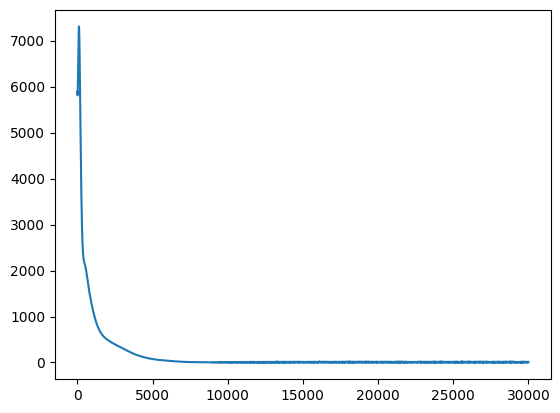

In [30]:
# Adam
f4 = adam(J, df, X0, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=10**(-8), numb_iter=N)
plt.plot(f4[0])

# Exercício 6: 

Implemente num mesmo gráfico os erros $\Vert\nabla f(X_k)\Vert$ de cada método em função no número de iterações.

C:\Users\dudda\AppData\Local\Temp\ipykernel_20144\3530018072.py:35: RuntimeWarning: overflow encountered in matmul
  grad_U = residual @ V  # (m, n) @ (n, r) -> (m, r)
C:\Users\dudda\AppData\Local\Temp\ipykernel_20144\3530018072.py:36: RuntimeWarning: overflow encountered in matmul
  grad_V = residual.T @ U  # (n, m) @ (m, r) -> (n, r)
C:\Users\dudda\AppData\Local\Temp\ipykernel_20144\3530018072.py:31: RuntimeWarning: invalid value encountered in matmul
  UV = U @ V.T  # Produto das matrizes U e V transposta


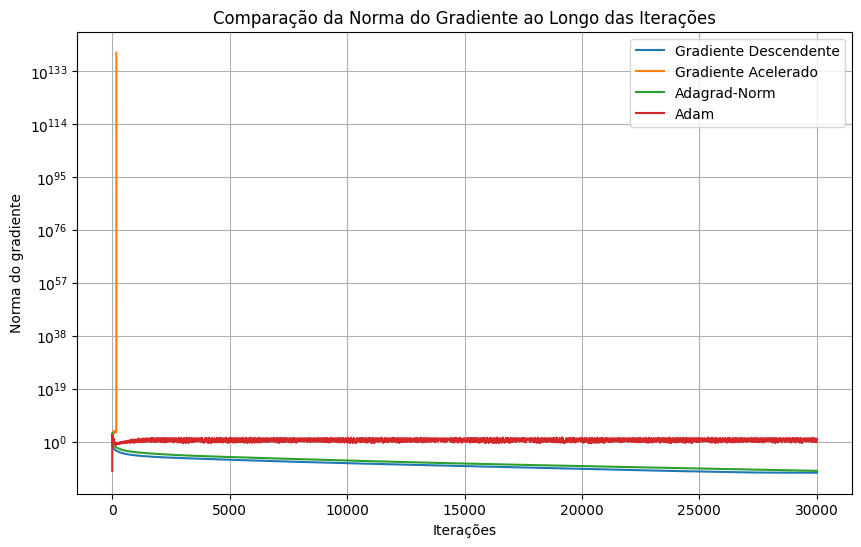

In [ ]:
# Definir os parâmetros comuns para todos os métodos
L = 1000
N = 30000
alpha = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Executar cada método

# Gradiente Descendente
grad_seq_gd, _ = gd(J, df, X0, la=1./L, numb_iter=N)

# Gradiente Acelerado
grad_seq_accel_gd, _ = accel_gd(J, df, X0, la=1./L, numb_iter=N)

# Adagrad-Norm
grad_seq_adagrad, _ = ad_grad_norm(J, df, X0, b0=0.5, eta=1, numb_iter=N)

# Adam
grad_seq_adam, _ = adam(J, df, X0, alpha, beta1, beta2, epsilon, numb_iter=N)

# Plotar os resultados
plt.figure(figsize=(10, 6))

# Plotar a norma do gradiente para cada método
plt.plot(grad_seq_gd, label='Gradiente Descendente')
plt.plot(grad_seq_accel_gd, label='Gradiente Acelerado')
plt.plot(grad_seq_adagrad, label='Adagrad-Norm')
plt.plot(grad_seq_adam, label='Adam')

# Configurações do gráfico
plt.xlabel('Iterações')
plt.ylabel('Norma do gradiente')
plt.title('Comparação da Norma do Gradiente ao Longo das Iterações')
plt.legend()
plt.grid(True)
plt.yscale('log')  # Para visualização clara em escala logarítmica

# Mostrar o gráfico
plt.show()

# Exercício 7:

Experimente com os hyper-parâmetros de Adagrad-Norm e Adam para ver se eles podem chegar perto ou superar a performance de GD e Nesterov. Plote o gráfico como no Exercício 6. 

C:\Users\dudda\AppData\Local\Temp\ipykernel_20144\3032345057.py:44: RuntimeWarning: overflow encountered in square
  grad_norm = np.sqrt(np.sum(grad_U**2) + np.sum(grad_V**2))
C:\Users\dudda\AppData\Local\Temp\ipykernel_20144\3530018072.py:31: RuntimeWarning: overflow encountered in matmul
  UV = U @ V.T  # Produto das matrizes U e V transposta
C:\Users\dudda\AppData\Local\Temp\ipykernel_20144\3530018072.py:31: RuntimeWarning: invalid value encountered in matmul
  UV = U @ V.T  # Produto das matrizes U e V transposta


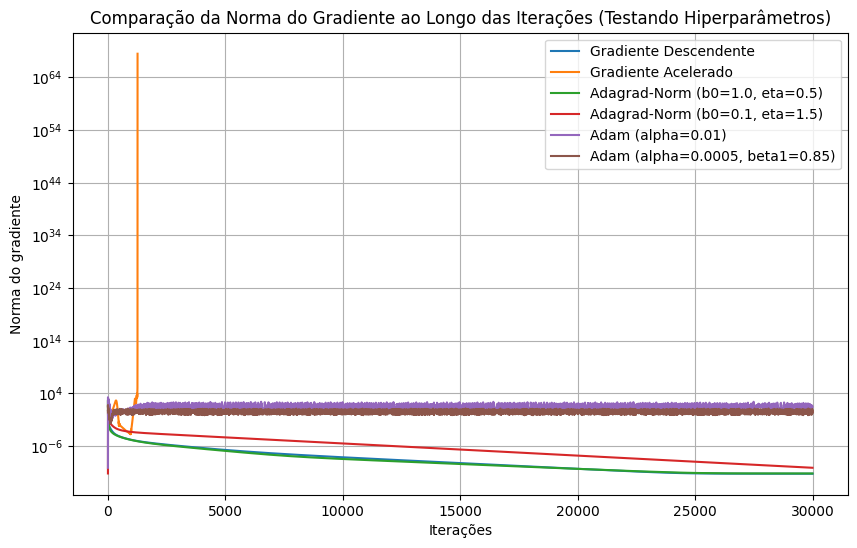

In [ ]:
# Parâmetros comuns
L = 1000
N = 30000
alpha = 0.001 
beta1 = 0.9     
beta2 = 0.999   
epsilon = 1e-8  

# Testando variações nos hiperparâmetros de Adagrad-Norm e Adam

# Adagrad-Norm com b0=1.0 e eta=0.5
grad_seq_adagrad_v1, _ = ad_grad_norm(J, df, X0, b0=1.0, eta=0.5, numb_iter=N)

# Adagrad-Norm com b0=0.1 e eta=1.5
grad_seq_adagrad_v2, _ = ad_grad_norm(J, df, X0, b0=0.1, eta=1.5, numb_iter=N)

# Adam com alpha=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8
grad_seq_adam_v1, _ = adam(J, df, X0, alpha=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, numb_iter=N)

# Adam com alpha=0.0005, beta1=0.85, beta2=0.99, epsilon=1e-6
grad_seq_adam_v2, _ = adam(J, df, X0, alpha=0.0005, beta1=0.85, beta2=0.99, epsilon=1e-6, numb_iter=N)

# Gradiente Descendente (para comparação)
grad_seq_gd, _ = gd(J, df, X0, la=1./L, numb_iter=N)

# Gradiente Acelerado de Nesterov (para comparação)
grad_seq_accel_gd, _ = accel_gd(J, df, X0, la=1./L, numb_iter=N)

# Plotar os erros de cada método
plt.figure(figsize=(10, 6))

# Plotar a norma do gradiente para cada método
plt.plot(grad_seq_gd, label='Gradiente Descendente')
plt.plot(grad_seq_accel_gd, label='Gradiente Acelerado')
plt.plot(grad_seq_adagrad_v1, label='Adagrad-Norm (b0=1.0, eta=0.5)')
plt.plot(grad_seq_adagrad_v2, label='Adagrad-Norm (b0=0.1, eta=1.5)')
plt.plot(grad_seq_adam_v1, label='Adam (alpha=0.01)')
plt.plot(grad_seq_adam_v2, label='Adam (alpha=0.0005, beta1=0.85)')

# Configurações do gráfico
plt.xlabel('Iterações')
plt.ylabel('Norma do gradiente')
plt.title('Comparação da Norma do Gradiente ao Longo das Iterações (Testando Hiperparâmetros)')
plt.legend()
plt.grid(True)
plt.yscale('log')  

# Mostrar o gráfico
plt.show()